In [1]:
#all of the imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [3]:
#Root directory
data_dir = 'EUROSAT_RGB/EuroSAT_RGB'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    #Size of the images after they are coming into the model.  Reduced size, which leads to fster run times but could be sacrificing some accuracy.  Could
    #possibly be a plus side as due to the reduction in the data granularity might prevent overfitting.
    transforms.Resize((64, 64)),
    #Flipping for data augmentation to add robustness to dataset
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #Makes it a tensor for use in the resnet model
    transforms.ToTensor(),
    #Standardizing to these values as this is what the imagenet dataset was trained on, so that the data will work more smoothly with the model
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loading the dataset from the root directory and applying the transform on it
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Print class names to verify they loaded in correctly
print("Classes:", dataset.classes)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [7]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: EUROSAT_RGB/EuroSAT_RGB
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


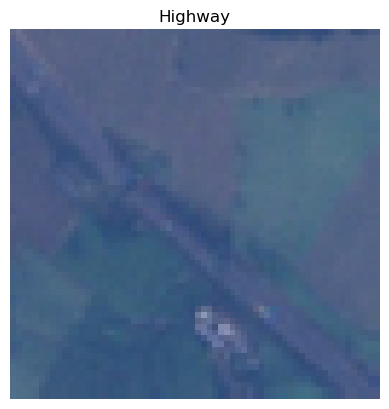

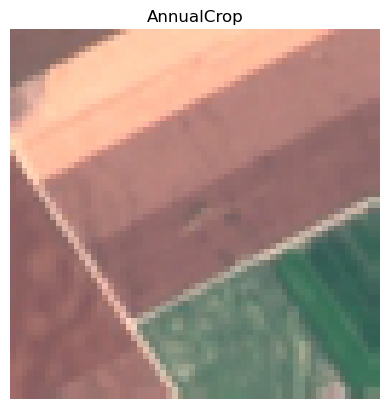

In [9]:
image, label = dataset[10000] 

#Short function that can create an image of a given image at a given index
def create_image(img):
    #Changes the image into the correct order.  Was color, height, width. Became height, width, color.  
    img = img.permute(1, 2, 0)
    #Reverses the normalization of the image (would be very blue otherwise)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  # Ensure valid range
    #Grabs the title of the label from the dataset class list
    plt.title(dataset.classes[label])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

image, label = dataset[10000] 
create_image(image)
image, label = dataset[100] 
create_image(image)

Epoch:  1
Train Loss:  0.3855838748198506
Val Loss:  0.3031127001916946
Val Accuracy:  89.55555555555556
Epoch:  2
Train Loss:  0.24425979202764259
Val Loss:  0.2152513220559719
Val Accuracy:  92.85185185185185
Epoch:  3
Train Loss:  0.20332579653257052
Val Loss:  0.2834192048325095
Val Accuracy:  89.88888888888889
Epoch:  4
Train Loss:  0.1916760168654995
Val Loss:  0.18059264459149088
Val Accuracy:  94.03703703703704
Epoch:  5
Train Loss:  0.15697931043954716
Val Loss:  0.152309974525557
Val Accuracy:  94.92592592592592
Epoch:  6
Train Loss:  0.14905013023825311
Val Loss:  0.15201785969872808
Val Accuracy:  95.03703703703704
Epoch:  7
Train Loss:  0.15147783824972608
Val Loss:  0.14505015961219406
Val Accuracy:  95.22222222222223
Epoch:  8
Train Loss:  0.11920313860881268
Val Loss:  0.1983814820820509
Val Accuracy:  93.74074074074075
Epoch:  9
Train Loss:  0.11815525011027332
Val Loss:  0.35382667998241824
Val Accuracy:  89.66666666666667
Epoch:  10
Train Loss:  0.1202878519826619
Va

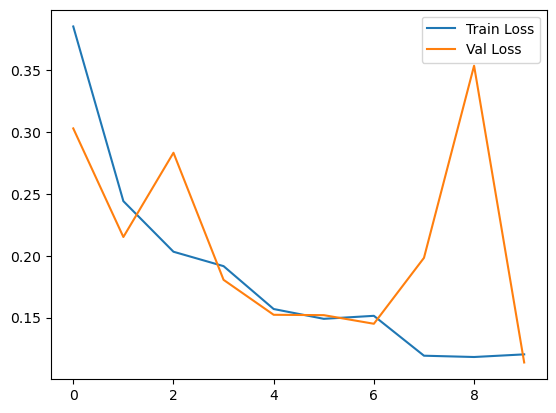

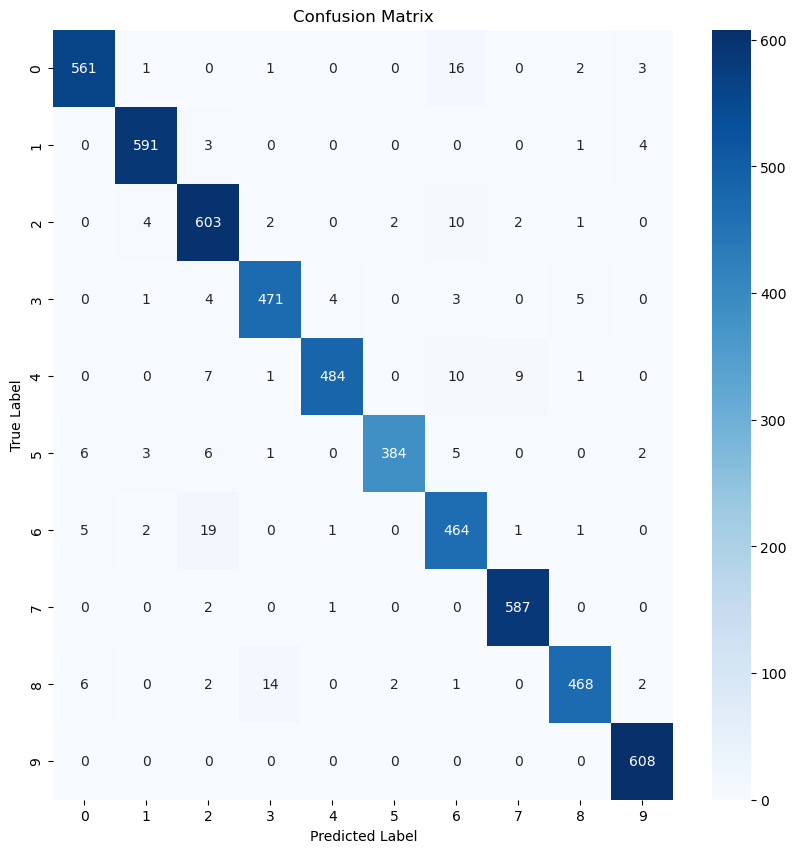

Test Loss:  0.10185502828920588
Test Accuracy:  96.68518518518519


In [17]:
#Grab the length of the data set and the indices of the data set
dataset_size = len(dataset)
indices = list(range(dataset_size))

#train test split does not have a validation set option, so first split into train indices and non-train indices
train_indices, non_train_indices = train_test_split(indices, test_size=0.3, random_state=0)

#This train test split is the remaining 30% of the data, so keeping about two thirds of the data for testing and one third for validation results
#in a train val test split of 0.7, 0.1, and 0.2 respectively, which is appears to be a fairly standard split for training using CNN's
val_indices, test_indices = train_test_split(non_train_indices, test_size=0.6666666, random_state=0)

#Create new data sets using the indices created by train test split
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

#Create a dataloader for this train/val/split using the new data sets that were created.  Shuffled the train loader as the order of the data could be
#Important during the training, as you do not want a batch that is predominantly all one class, thus the trainloader should be shuffled.  Batch size
#is 64 as this will being a good balance of training speed without a strong propensity for overfitting.  
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)



#Using pretrain resnet18 model, hence why we had normalization earlier.  It is pretrained on the imagenet data set, which is a large dataset used to
#to benchmark many models.  
model = models.resnet18(pretrained=True)
#The number of classes in the data set
class_num = len(dataset.classes)

# Modify the last layer to match the number of classes, as the pretrained model has 1000 classes, which must be changed to the number of classes we actually have
model.fc = nn.Linear(model.fc.in_features, class_num)
#Sets the device the model will be trained on
model = model.to(device)

#Loss function is cross entropy, as this is typically seen as a good choice for multiclass datasets
crit = nn.CrossEntropyLoss()
#Using an weighted adam optimizer, which can lead to quick convergence and better weight decay, which makes the model more generalizable
optimizer = optim.AdamW(model.parameters(), lr=0.001)

#Using 10 epochs, as this is considered the minimum for a small data set
num_epochs = 10
tr_losses, val_losses = [], []
#Begin training model here:
for epoch in range(num_epochs):
    #Put the model in training mode
    model.train()
    #Start counting the total loss
    loss_total = 0.0
    #This for goes through each of the images and corresponding labels in a batch in the train_dataloader, and then applies the model to it
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        #resets the gradients batch to batch
        optimizer.zero_grad()
        #Grabs output of the model from the images
        sout = model(images)
        #Calculates loss, computes gradient, and updates parameters
        loss = crit(sout, labels)
        loss.backward()
        optimizer.step()
        #just to see if the program is running initially
        #print("working")
        #Add to the total loss of the epoch
        loss_total += loss.item()
    #Calculate the average loss over the entire epoch
    avg_tr_loss = loss_total / len(trainloader)
    #Adds the train losses to the list for plotting
    tr_losses.append(avg_tr_loss)

    #Puts model in evaluation mode and resets/initializes variables for evaluation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    #Disable gradient calculation as this is just for evaluation
    with torch.no_grad():
        #Going through each batch in valloader
        for images, labels in valloader:
            #Repeat steps from training block, but do not update the gradients or parameters
            images, labels = images.to(device), labels.to(device)
            sout = model(images)
            #Calculated loss 
            loss = crit(sout, labels)
            val_loss += loss.item()
            #Grabbing the index of the maximum value, which matches to its predicted class
            predicted = torch.argmax(sout, dim=1)
            #Gets the total number of images that are being tested
            total += labels.shape[0]
            #Compares the predicted to the labels, and sums the amount that are correct
            correct += (predicted == labels).sum().item()  
    #Computes the average val loss for the validation set of this epoch
    avg_val_loss = val_loss / len(valloader)
    #Adds it to the list for graphing
    val_losses.append(avg_val_loss)
    #Calculates validation accuracy
    val_accuracy = 100. * correct / total
    #Print some of the metrics that we are using per epoch for information during training
    print("Epoch: ",(epoch+1))
    print("Train Loss: ",avg_tr_loss)
    print("Val Loss: ",avg_val_loss)
    print("Val Accuracy: ",val_accuracy)

# Plot training and validation loss
plt.plot(range(num_epochs), tr_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.legend()
plt.show()

#Set the mode to evaluation for the final testing of the data on test data
model.eval()
test_loss = 0.0
correct = 0
total = 0
#Creating lists for confusion matrix
preds = []
test_labels = []
#Stops computing gradient for testing data
with torch.no_grad():
    #Going through each batch in the testloader
    for images, labels in testloader:
        #Grabs images and labels
        images, labels = images.to(device), labels.to(device)
        #Gets the model output
        sout = model(images)
        #Caclulates loss
        loss = crit(sout, labels)
        #adds to the total loss of the epoch
        test_loss += loss.item()
        #Grabbing the index of the maximum value, which matches to its predicted class
        predicted = torch.argmax(sout, dim=1)
        #Gets the total number of images that are being tested
        total += labels.shape[0]
        #Compares the predicted to the labels, and sums the amount that are correct
        correct += (predicted == labels).sum().item()  
        #Store the labels and predicted for use in a confusion matrix
        preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
#Convert the predictions and labels from test to use for confusion matrix
preds = np.array(preds)
test_labels = np.array(test_labels)

#Creating the confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)

#Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(class_num), yticklabels=range(class_num))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#Gets the average_test_loss
avg_test_loss = test_loss / len(testloader)
#Gets the test accuracy
test_accuracy = 100 * correct / total
#Prints the final results of the model
print("Test Loss: ", avg_test_loss)
print("Test Accuracy: ", test_accuracy)
